## Finilizing Data Generation for PSR System

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

from scipy.integrate import solve_ivp

3.8.9 (default, Apr  3 2021, 01:51:00) 
[Clang 12.0.0 (clang-1200.0.32.29)]


In [2]:
### Input Data

OutputDir  = WORKSPACE_PATH+'/ROMNet/Data/PSR_10Cases/'
TestDir    = WORKSPACE_PATH+'/ROMNet/Data/PSR_10Cases_Test/'
try:
    os.makedirs(OutputDir)
except OSError as e:
    pass
try:
    os.makedirs(TestDir)
except OSError as e:
    pass

NVarsRed           = 3

NPerRestTrain      = 2000
tStratch           = 1.
NtTrain            = NPerRestTrain*2
SOLVER             = 'BDF'

In [3]:
### Retrieving Data

Vars = []
for iVars in range(1,NVarsRed+1):
    Vars.append('PC_'+str(iVars))

SVars = []
for iVars in range(1,NVarsRed+1):
    SVars.append('SPC_'+str(iVars))

FileName     = OutputDir + '/orig_data/RestVecTot.csv'
Data         = pd.read_csv(FileName, header=None)
RestVecTot   = np.log10(Data.to_numpy())
    
# FileName     = OutputDir+'/orig_data/t.csv'
# Data         = pd.read_csv(FileName, header=None)
# tVec         = Data.to_numpy()[:,0]

# FileName     = OutputDir + '/orig_data/yCleaned.csv'
# yMatOrig     = pd.read_csv(FileName, header=0)
# VarNames     = list(yMatOrig.columns)
# yMat         = yMatOrig.to_numpy()

FileName             = OutputDir+'/pc_data_'+str(NVarsRed)+'/PC.csv'
Data                 = pd.read_csv(FileName, header=0)
Data['log10(t)']     = np.log10(Data.t.to_numpy()+1.e-20)
Data['log10(Rest)']  = RestVecTot
Data['Rest']         = 10.**RestVecTot
yMat_pca             = Data[Vars].to_numpy()

FileName             = OutputDir+'/pc_data_'+str(NVarsRed)+'/PCSource.csv'
DataS                = pd.read_csv(FileName, header=0)
DataS['log10(t)']    = np.log10(Data.t.to_numpy()+1.e-20)
DataS['log10(Rest)'] = RestVecTot
DataS['Rest']        = 10.**RestVecTot
ySource_pca          = DataS[SVars].to_numpy()


### Writing Input
InputVar     = ['t', 'log10(t)', 'Rest', 'log10(Rest)']
DataInput    = Data[InputVar]
DataInput.to_csv(OutputDir+'/pc_data_'+str(NVarsRed)+'/Input.csv', index=False)
tVec         = DataInput.t.to_numpy()


### Writing PCs
Data.to_csv(OutputDir+'/pc_data_'+str(NVarsRed)+'/Output.csv', index=False)


### Normalizing PCs' Source Terms
yMax         = ySource_pca.max(0)
yMin         = ySource_pca.min(0)
yRange       = (yMax-yMin)
yScale       = np.concatenate([yMin[...,np.newaxis], yMax[...,np.newaxis]], axis=1)
np.savetxt(OutputDir+'/pc_data_'+str(NVarsRed)+'/MinMax.csv', yScale, header='Min,Max', comments='', delimiter=',')

ySourcee_pca = (ySource_pca - yMin)/yRange
#ySourcee_pca = (ySource_pca - yMin)/yRange[0]

for iPC in range(NVarsRed):
    DataS['SPC_'+str(iPC+1)+'_Scaled'] = ySourcee_pca[:,iPC]
DataS.to_csv(OutputDir+'/pc_data_'+str(NVarsRed)+'/dOutput.csv', index=False)

Text(0.5, 0, '$dPC_3/dt$')

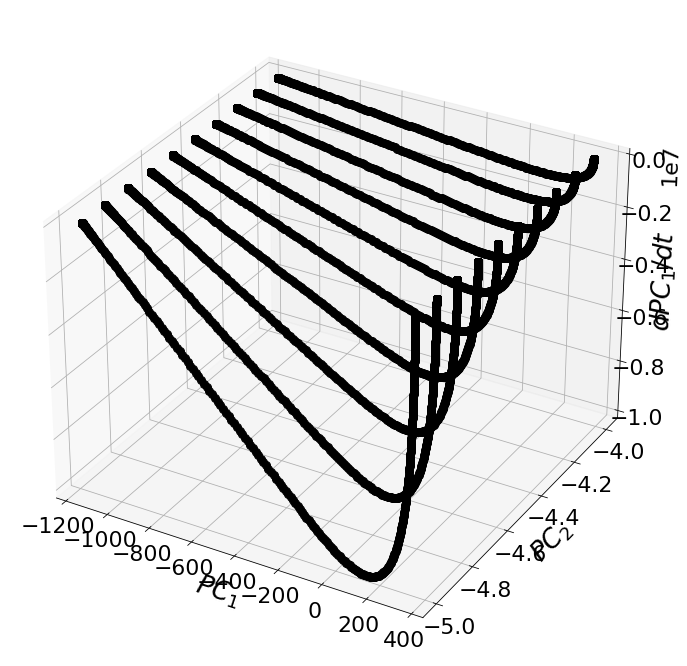

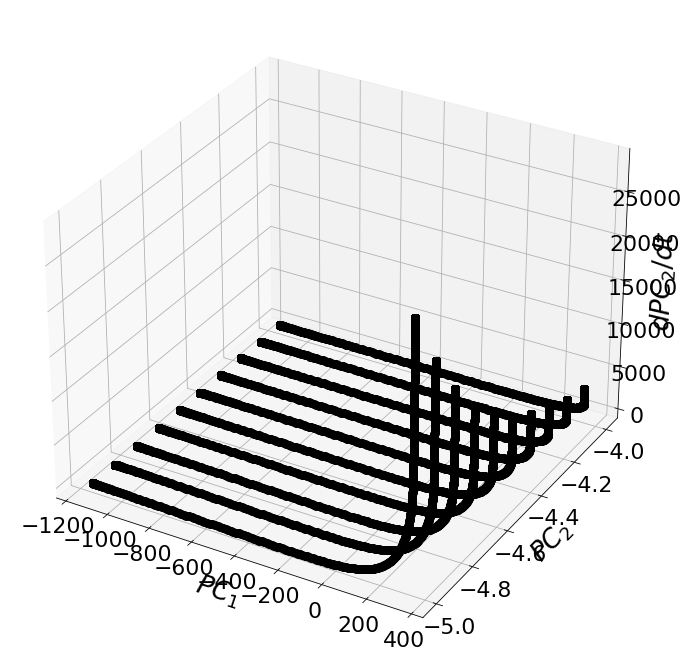

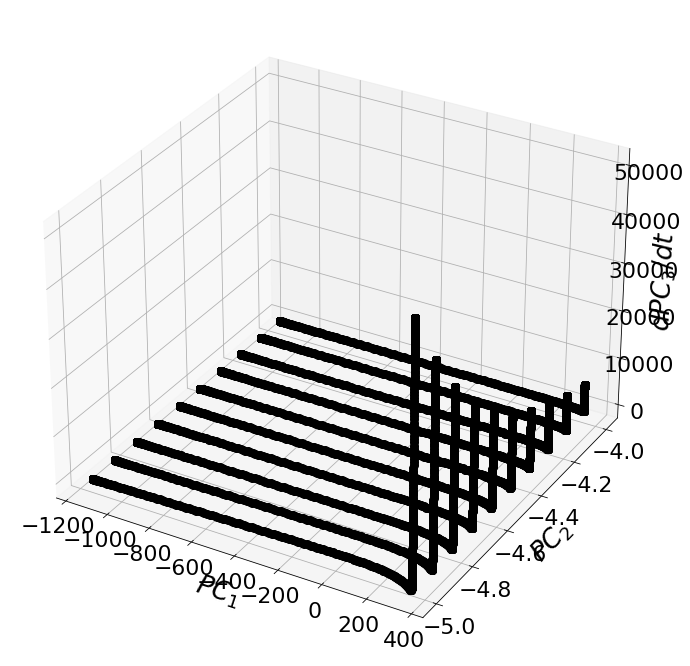

In [4]:
# Plotting Sources vs States

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat_pca[:,0], RestVecTot, ySource_pca[:,0], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_1/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat_pca[:,0], RestVecTot, ySource_pca[:,1], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_2/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat_pca[:,0], RestVecTot, ySource_pca[:,2], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_3/dt$')

Text(0.5, 0, '$dPC_3/dt$')

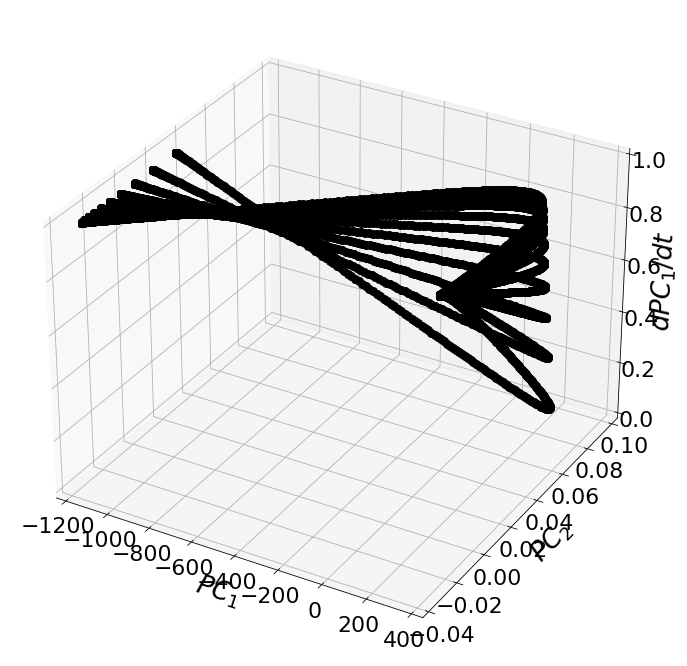

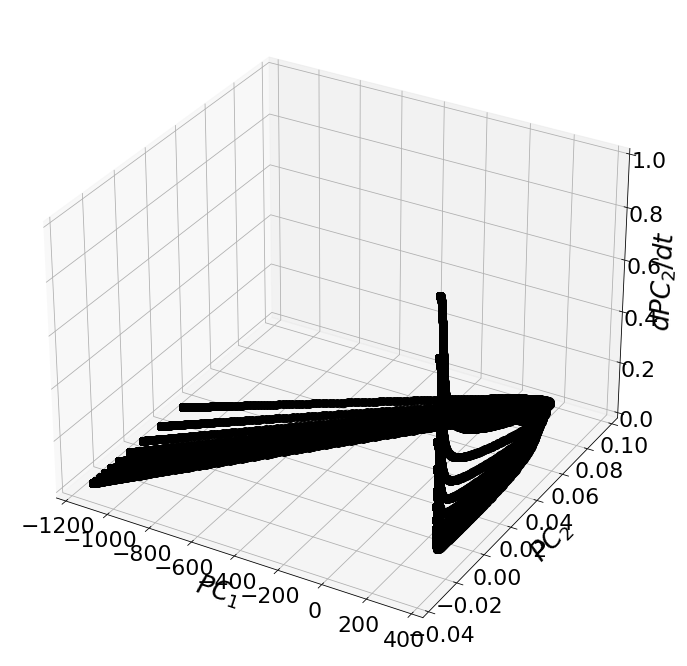

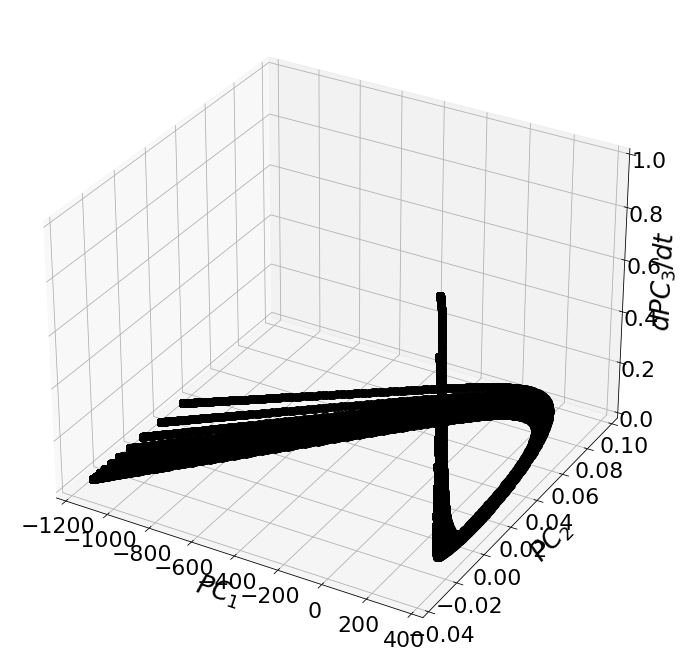

In [5]:
# Plotting Sources vs States

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMat_pca[:,0], yMat_pca[:,1], ySourcee_pca[:,0], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_1/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMat_pca[:,0], yMat_pca[:,1], ySourcee_pca[:,1], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_2/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMat_pca[:,0], yMat_pca[:,1], ySourcee_pca[:,2], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_3/dt$')

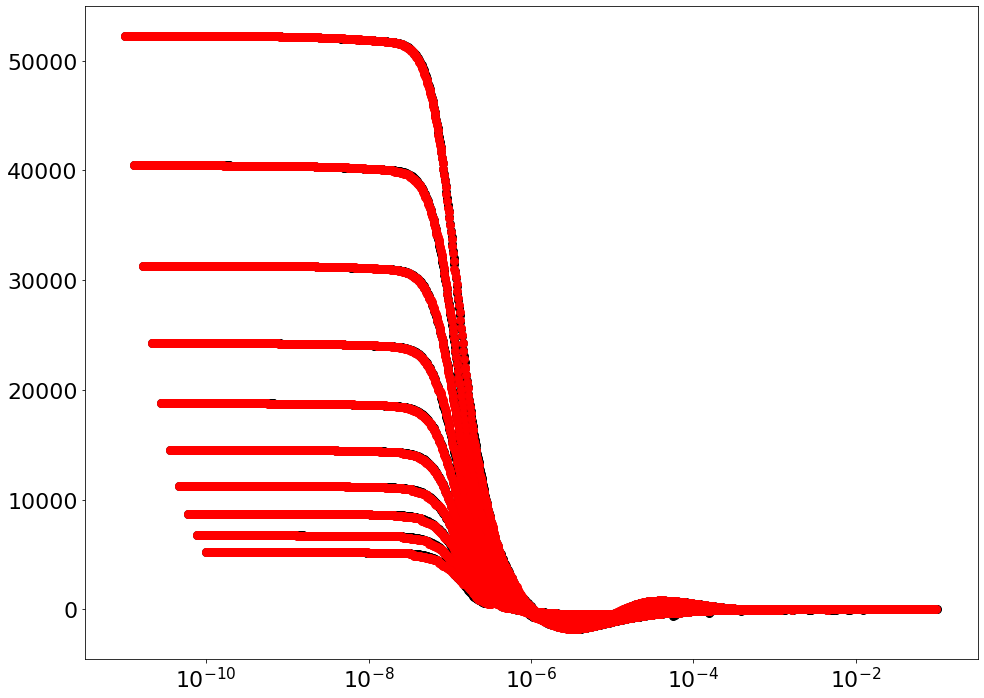

In [6]:
### Checking Data

from numpy import diff

iPC = 2

dydt = diff(yMat_pca[:,iPC])/diff(tVec)

fig = plt.figure(figsize=(16,12))
plt.plot(tVec, ySource_pca[:,iPC], 'ko')
plt.plot(tVec[0:-1], dydt, 'ro')
plt.xscale('log')

In [7]:
### Retrieving Data

Vars = []
for iVars in range(1,NVarsRed+1):
    Vars.append('PC_'+str(iVars))

SVars = []
for iVars in range(1,NVarsRed+1):
    SVars.append('SPC_'+str(iVars))

FileName     = TestDir + '/orig_data/RestVecTot.csv'
Data         = pd.read_csv(FileName, header=None)
RestVecTot   = np.log10(Data.to_numpy())
    
# FileName     = TestDir+'/orig_data/t.csv'
# Data         = pd.read_csv(FileName, header=None)
# tVec         = Data.to_numpy()[:,0]

# FileName     = TestDir + '/orig_data/yCleaned.csv'
# yMatOrig     = pd.read_csv(FileName, header=0)
# VarNames     = list(yMatOrig.columns)
# yMat         = yMatOrig.to_numpy()

FileName             = TestDir+'/pc_data_'+str(NVarsRed)+'/PC.csv'
Data                 = pd.read_csv(FileName, header=0)
Data['log10(t)']     = np.log10(Data.t.to_numpy()+1.e-20)
Data['log10(Rest)']  = RestVecTot
Data['Rest']         = 10.**RestVecTot
yMat_pca             = Data[Vars].to_numpy()

FileName             = TestDir+'/pc_data_'+str(NVarsRed)+'/PCSource.csv'
DataS                = pd.read_csv(FileName, header=0)
DataS['log10(t)']    = np.log10(Data.t.to_numpy()+1.e-20)
DataS['log10(Rest)'] = RestVecTot
DataS['Rest']        = 10.**RestVecTot
ySource_pca          = DataS[SVars].to_numpy()


### Writing Input
InputVar     = ['t', 'log10(t)', 'Rest', 'log10(Rest)']
DataInput    = Data[InputVar]
DataInput.to_csv(TestDir+'/pc_data_'+str(NVarsRed)+'/Input.csv', index=False)
tVec         = DataInput.t.to_numpy()


### Writing PCs
Data.to_csv(TestDir+'/pc_data_'+str(NVarsRed)+'/Output.csv', index=False)


### Normalizing PCs' Source Terms
ySourcee_pca = (ySource_pca - yMin)/yRange
#ySourcee_pca = (ySource_pca - yMin)/yRange[0]

for iPC in range(NVarsRed):
    DataS['SPC_'+str(iPC+1)+'_Scaled'] = ySourcee_pca[:,iPC]
DataS.to_csv(TestDir+'/pc_data_'+str(NVarsRed)+'/dOutput.csv', index=False)